#  Imports

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras import Model
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocesado


In [7]:
def load_and_rotate_image(file_path, image_size=224):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    label = k
    image = tf.image.rot90(image, k=k)
    image = (image / 127.5) - 1.0
    return image, label



## Crear dataset

In [8]:
def create_rotnet_dataset(image_dir, image_size=224, batch_size=32):
    print(f"📁 Cargando imágenes desde: {image_dir}")

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for fname in files:
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(root, fname))
    print(f"🔢 Total de imágenes encontradas: {len(image_paths)}")
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    ])
    # dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    # dataset = dataset.map(preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.shuffle(1000)
    # dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(tf.data.AUTOTUNE)
    # Crear el dataset desde las rutas
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Mapear con la función de carga y rotación
    dataset = dataset.map(lambda path: load_and_rotate_image(path, image_size=image_size),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Aplicar data augmentation
    dataset = dataset.map(lambda image, label: (data_augmentation(image), label),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Barajar, agrupar en lotes y prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    print(f"⏱️ Preprocesamiento completado.\n")

    return dataset


In [9]:
image_dir = "e:/TFM/DB/pocRotnet"
image_dir="e:/TFM/PlantsClassification/train"
# image_dir = os.path.join(execution_path,  "pocRotnet")
train = create_rotnet_dataset("e:/TFM/PlantsClassification/train")
test= create_rotnet_dataset("e:/TFM/PlantsClassification/test")
val= create_rotnet_dataset("e:/TFM/PlantsClassification/val")

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/train
🔢 Total de imágenes encontradas: 21000
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/test
🔢 Total de imágenes encontradas: 6000
⏱️ Preprocesamiento completado.

📁 Cargando imágenes desde: e:/TFM/PlantsClassification/val
🔢 Total de imágenes encontradas: 3000
⏱️ Preprocesamiento completado.



##  Definir modelo

In [12]:
model = base_model = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation="softmax")  # 4 clases: 0, 90, 180, 270 grados
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


## Ejecutar entrenamiento

In [13]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("🚀 Comenzando el entrenamiento...\n")

for batch in train.take(1):
    x, y = batch
    print("🧪 x shape:", x.shape)
    print("🧪 y shape:", y.shape)
    print("🧪 y dtype:", y.dtype)
    print("🧪 y example:", y[0])
# history = model.fit(dataset, epochs=100, verbose=2)
history=model.fit(
    train,                # tf.data.Dataset o generator
    verbose=1,          # Mostrar progreso
    validation_data=test, # validación con rotaciones también
    epochs=50,
    batch_size=128,               # Puedes probar 64 o 128 según tu GPU
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",  # Monitorear la pérdida en los datos de validación
            patience=5,  # Aumentar la paciencia para permitir más iteraciones
            restore_best_weights=True,  # Restaurar los mejores pesos al final
            min_delta=1e-4,  # Mínima mejora requerida para considerar un cambio significativo
            verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

# history = model.fit(
#     train,
#     epochs=200,
#     verbose=1,
#     validation_data=val,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor="val_loss",  # Monitorear la pérdida en los datos de validación
#             patience=10,  # Aumentar la paciencia para permitir más iteraciones
#             restore_best_weights=True,  # Restaurar los mejores pesos al final
#             min_delta=1e-4,  # Mínima mejora requerida para considerar un cambio significativo
#             verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
#         ),
#         tf.keras.callbacks.ModelCheckpoint(
#             "best_rotnet_model.keras",
#             monitor="val_loss",  # Guardar el mejor modelo basado en la pérdida de validación
#             save_best_only=True,
#             verbose=1
#         )
#     ]
# )


print(f"\n✅ Entrenamiento finalizado.")

save_path = "E:/TFM/rotnet_model.keras"
model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


🚀 Comenzando el entrenamiento...

🧪 x shape: (32, 224, 224, 3)
🧪 y shape: (32,)
🧪 y dtype: <dtype: 'int32'>
🧪 y example: tf.Tensor(3, shape=(), dtype=int32)
Epoch 1/50
657/657 [==============================] - 167s 244ms/step - loss: 1.4836 - accuracy: 0.3060 - val_loss: 3.6802 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 2/50
657/657 [==============================] - 160s 241ms/step - loss: 1.3323 - accuracy: 0.3810 - val_loss: 1.3354 - val_accuracy: 0.3558 - lr: 0.0010
Epoch 3/50
657/657 [==============================] - 161s 243ms/step - loss: 1.2936 - accuracy: 0.4034 - val_loss: 101.5724 - val_accuracy: 0.2618 - lr: 0.0010
Epoch 4/50
657/657 [==============================] - 161s 243ms/step - loss: 1.2724 - accuracy: 0.4227 - val_loss: 1.2806 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 5/50
657/657 [==============================] - 160s 242ms/step - loss: 1.2250 - accuracy: 0.4482 - val_loss: 1.2901 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 6/50
657/657 [==========================

## Visualizar

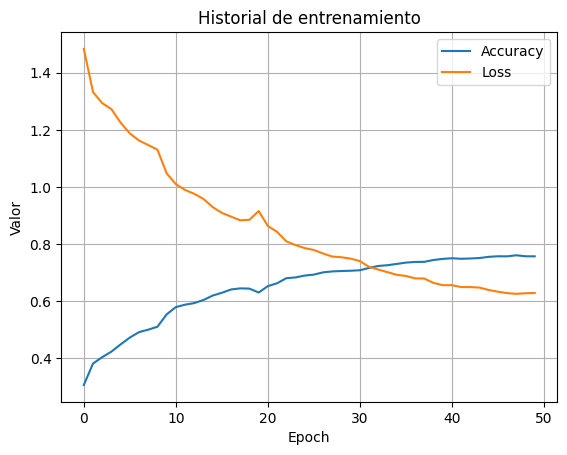

In [14]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["loss"], label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Historial de entrenamiento")
plt.legend()
plt.grid()
plt.show()


1/1 [==============================] - 1s 838ms/step


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (30).

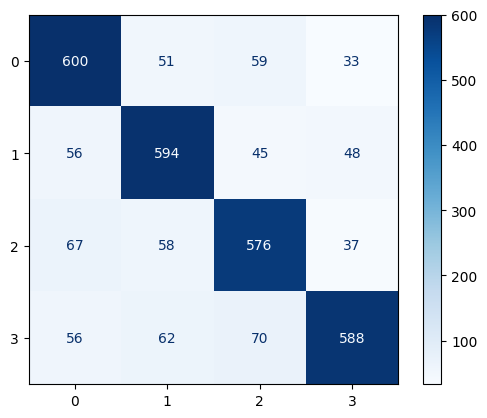

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(30))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [16]:
import pickle

history_path = "E:/TFM/history.pkl"
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"💾 Historial guardado en: {history_path}")


💾 Historial guardado en: E:/TFM/history.pkl


In [17]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/train',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/test',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='E:/TFM/PlantsClassification/val',
    labels='inferred',
    label_mode='int',         # entero para usar sparse_categorical_crossentropy
    batch_size=64,
    image_size=(224, 224),    # ajusta si usas otra entrada en tu modelo
    shuffle=True,
    seed=42
)

Found 21000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.


In [27]:
tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3)).summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [41]:
rotnet_model= model
encoder = Model(
    inputs=rotnet_model.input,
    outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
)
for layer in encoder.layers:
    layer.trainable = False  # o True si vas a hacer fine-tuning
plant_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, 2048)),  # Adjust input shape to match encoder output
    tf.keras.layers.Reshape((32, 64, 1)),  # Reshape to add spatial dimensions
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(30, activation='softmax')
])
plant_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 32, 64, 1)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 64, 256)       2560      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 32, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 32, 128)       295040    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 16, 128)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 16384)           

In [ ]:
# encoder=rotnet_model=model = base_model = tf.keras.applications.MobileNetV2(weights="imagenet",include_top=True, input_shape=(224, 224, 3))
# encoder.trainable = False  # Congelar el modelo base
rotnet_model= model
encoder = Model(
    inputs=rotnet_model.input,
    outputs=rotnet_model.layers[-2].output  # penúltima capa (antes de Dense(4))
)
for layer in encoder.layers:
    layer.trainable = False  # o True si vas a hacer fine-tuning
plant_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Flatten(),  # or GlobalAveragePooling2D() if Flatten hasn't been applied earlier
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30, activation="softmax")
])
plant_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                      

In [42]:
plant_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2=plant_model.fit(
    train_dataset,  # tus datos con 30 clases verdaderas
    validation_data=test_dataset,
    verbose=1,
    epochs=50,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",  # Monitorear la pérdida en los datos de validación
            patience=5,  # Aumentar la paciencia para permitir más iteraciones
            restore_best_weights=True,  # Restaurar los mejores pesos al final
            min_delta=1e-3,  # Mínima mejora requerida para considerar un cambio significativo
            verbose=1  # Mostrar mensajes cuando se active el EarlyStopping
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        
    ]
)
save_path = "E:/TFM/plant_model_full.keras"
plant_model.save(save_path)
print(f"💾 Modelo guardado en: {save_path}")


Epoch 1/50


ValueError: in user code:

    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Usuario\miniconda3\envs\rotnet\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, None, 2048), found shape=(None, 224, 224, 3)


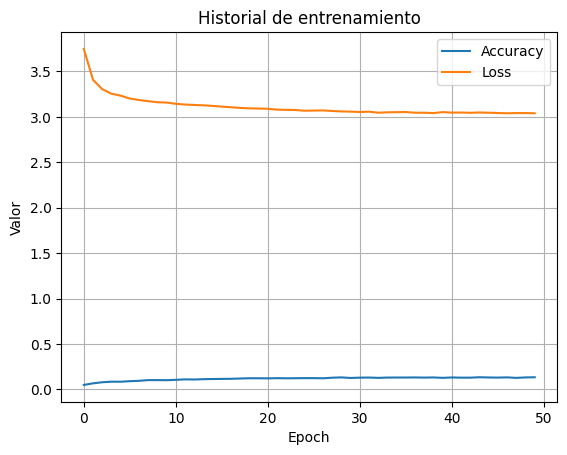

In [20]:
plt.plot(history2.history["accuracy"], label="Accuracy")
plt.plot(history2.history["loss"], label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("Historial de entrenamiento")
plt.legend()
plt.grid()
plt.show()

2/2 [==============================] - 1s 50ms/step


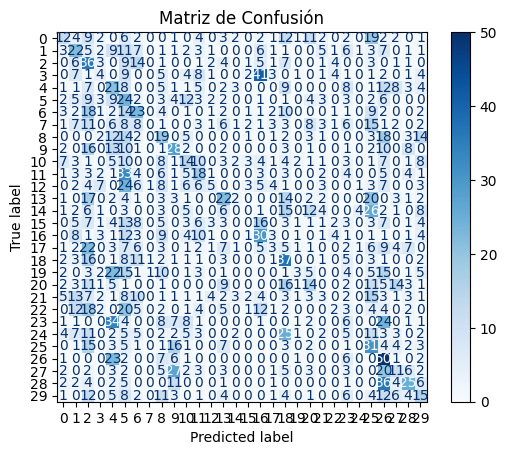

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Obtener predicciones y etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = plant_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(30))  # Ajusta el rango según tus clases
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()